# CuPy-based Bifurcation map

In [1]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot(r, history):
    plt.figure(figsize=(15, 5))
    plt.plot(r, history, 'k.', markersize=0.15)
    
    plt.title('Bifurcation map')
    plt.xlabel('r')
    plt.ylabel('x')

In [3]:
def logistic_map(r, x):
    return r * x * (1 - x)

In [4]:
logistic_map_karnel = cp.ElementwiseKernel(
    'float64 r, float64 x',
    'float64 z',
    'z = r * x * (1 - x)',
    'logistic_map_karnel'
)

In [5]:
SIZE = 6_500_000
N = 200
M = 200

# Numpy

In [6]:
def get_bifurcation_map(n, m, r):
    history = np.zeros((m, len(r)))
    x = np.random.uniform(size=len(r))
    
    for _ in range(n):
        x = logistic_map(r, x)
    for i in range(m):
        x = logistic_map(r, x)
        history[i] = x
    return history.T

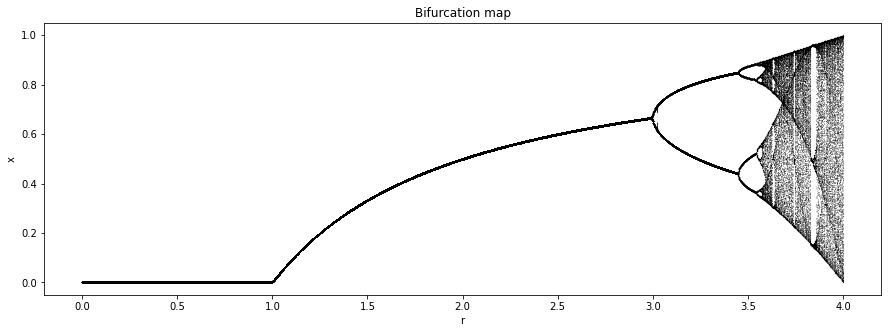

In [7]:
r_linspace = np.linspace(0, 4, num=2000)
history = get_bifurcation_map(N, M, r_linspace)
plot(r_linspace, history)

In [8]:
r_linspace = np.linspace(0, 4, num=SIZE)
time_np = %timeit -o -r 3 get_bifurcation_map(N, M, r_linspace)

16.6 s ± 3.26 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


# Cupy

In [9]:
def get_bifurcation_map_cupy(n, m, r, func):
    history = cp.zeros((m, len(r)))
    x = cp.random.uniform(size=len(r))
    
    for _ in range(n):
        x = func(r, x)
    for i in range(m):
        x = func(r, x)
        history[i] = x
    return history.T

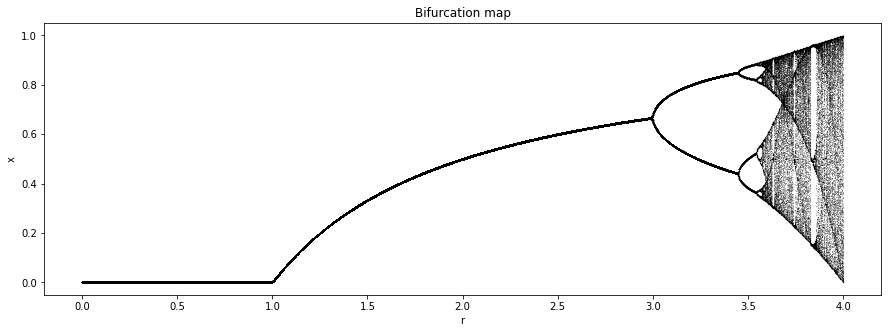

In [10]:
r_linspace = cp.linspace(0, 4, num=2000)
history = get_bifurcation_map_cupy(N, M, r_linspace, logistic_map)
plot(r_linspace.get(), history.get())

In [11]:
r_linspace = cp.linspace(0, 4, num=SIZE)
time_cp = %timeit -o -r 3 get_bifurcation_map_cupy(N, M, r_linspace, logistic_map)

367 ms ± 30.8 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [12]:
get_bifurcation_map_cupy(N, M, r_linspace, logistic_map_karnel)
time_cp_karnel = %timeit -o -r 3 get_bifurcation_map_cupy(N, M, r_linspace, logistic_map_karnel)

173 ms ± 10.4 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


## Difference

### Numpy vs Cupy

In [13]:
time_np.best / time_cp.best

45.208939970198784

### Numpy vs Cupy ElementwiseKernel

In [14]:
time_np.best / time_cp_karnel.best

95.74395055345371

### Cupy vs Cupy ElementwiseKernel

In [15]:
time_cp.best / time_cp_karnel.best

2.1178101193384986

## Profile

In [16]:
import cProfile

cProfile.run('get_bifurcation_map_cupy(N, M, r_linspace, logistic_map_karnel)')

         421 function calls in 0.142 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.142    0.142    0.142    0.142 3985020568.py:1(get_bifurcation_map_cupy)
        1    0.000    0.000    0.142    0.142 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 _distributions.py:822(uniform)
        1    0.000    0.000    0.000    0.000 _generator.py:1198(get_random_state)
        1    0.000    0.000    0.000    0.000 _generator.py:1234(_check_and_get_dtype)
        1    0.000    0.000    0.000    0.000 _generator.py:598(_random_sample_raw)
        1    0.000    0.000    0.000    0.000 _generator.py:608(random_sample)
        1    0.000    0.000    0.000    0.000 _generator.py:910(uniform)
        1    0.000    0.000    0.000    0.000 basic.py:194(zeros)
        1    0.000    0.000    0.000    0.000 basic.py:7(empty)
      202    0.000    0.000    0.000    0.000 numeric.py:1865(isscalar)
        1   

## Graph

In [17]:
array_of_sizes = np.arange(1_000, 6_501_000, 500_000)

In [18]:
time_np = np.zeros(array_of_sizes.size)
time_cp = np.zeros(array_of_sizes.size)
time_cp_kernel = np.zeros(array_of_sizes.size)
time_mpi = np.zeros(array_of_sizes.size)
for i, size in enumerate(array_of_sizes):
    print(f'\r{i+1}/{array_of_sizes.size}', end='')
    
    r_linspace = np.linspace(0, 4, num=size)
    time = %timeit -o -q -r 2 -n 1 get_bifurcation_map(N, M, r_linspace)
    time_np[i] = time.best
    
    time = %timeit -o -q -r 2 -n 1 !mpirun -n 18 python task_05_bm_map_mpi.py {size}
    time_mpi[i] = time.best
    
    r_linspace = cp.array(r_linspace)
    time = %timeit -o -q -r 2 -n 1 get_bifurcation_map_cupy(N, M, r_linspace, logistic_map)
    time_cp[i] = time.best
    
    time = %timeit -o -q -r 2 -n 1 get_bifurcation_map_cupy(N, M, r_linspace, logistic_map_karnel)
    time_cp_kernel[i] = time.best

13/13

Text(0, 0.5, 'Computation time')

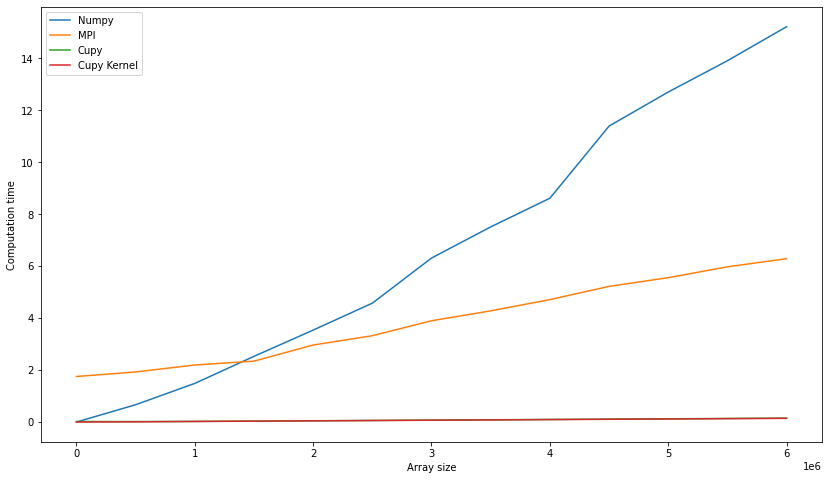

In [19]:
plt.figure(figsize=(14, 8))
plt.plot(array_of_sizes, time_np, label='Numpy')
plt.plot(array_of_sizes, time_mpi, label='MPI')
plt.plot(array_of_sizes, time_cp, label='Cupy')
plt.plot(array_of_sizes, time_cp_kernel, label='Cupy Kernel')
plt.legend()
plt.xlabel('Array size')
plt.ylabel('Computation time')

Text(0, 0.5, 'Computation time')

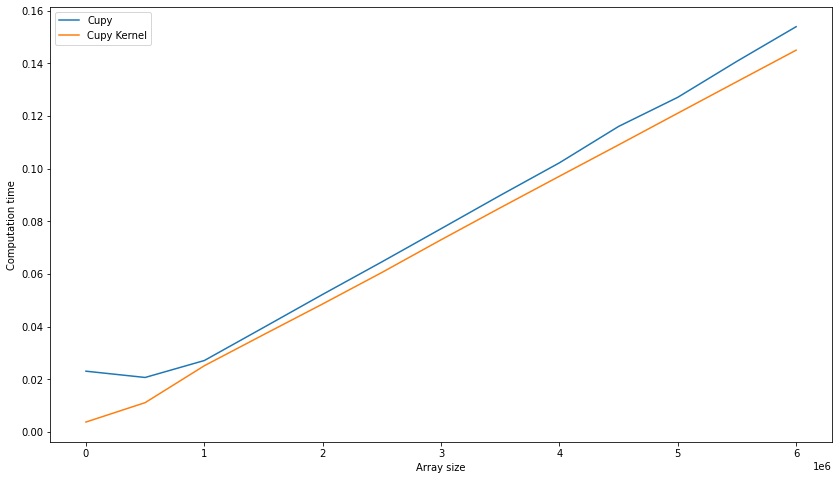

In [20]:
plt.figure(figsize=(14, 8))
plt.plot(array_of_sizes, time_cp, label='Cupy')
plt.plot(array_of_sizes, time_cp_kernel, label='Cupy Kernel')
plt.legend()
plt.xlabel('Array size')
plt.ylabel('Computation time')